---
title: "Quality Control: Relatedness"
format:
  html:
    code-fold: false
    toc: true
  ipynb:
    toc: true
    number-sections: false
bibliography: references/references_4.bib
---

::: {.callout-note title="Important notes for this notebook" icon=false}

As we have already mentioned, quality control (QC) analyses are crucial to ensure the reliability and validity of the results. In this section, we will explore **relatedness**, exploring some ways of estimating it, and how it can be used to check suality of the data.

## Learning outcomes

- **Discuss** Identity by descent and  its estimators in PLINK and PLINK2
- **Detect and categorize** related individuals
- **Identify and speculate** what can cause unusual relatedness

## How to make this notebook work

In this notebook, we will both use `R` and `bash command line` programming languages. Remember to **change the kernel** whenever you transition from one language to the other (`Kernel --> Change Kernel`) indicated by the languages' images.
* We will first run `Bash` commands.  
  
<img src="Images/bash.png" alt="Bash" width="80"> Choose the Bash kernel

:::

Relatedness refers to the presence of genetically related individuals in a study sample, which can introduce confounding factors into association analyses. Since most statistical methods assume that samples are independent, including related individuals, like siblings, violates this assumption. Addressing relatedness is crucial as a quality control step to ensure that genomes in the dataset are no more similar than expected for unrelated individuals. This process is essential to preserve the validity of the study's findings.

While all humans share some genetic relatedness, the degree of relatedness varies among individuals. In genome-wide association studies (GWAS), these variations must be accounted for to avoid biasing the statistical associations between genotypes and phenotypes. **Cryptic relatedness** (genetic relatedness of individuals not expected to be in a family relationship) can interfere with the association analysis [@voight2005confounding]. 

In a **family-based study** (e.g., parent-offspring), you do not need to remove related pairs, but the statistical analysis should account for family relatedness. However, for a **population-based study**, we suggest using the KING estimator [@KING2010] with a threshold of 0.06.

Differently from the IBD estimator (called pi_hat $\hat{\pi}$), which assumes that individuals come from homogeneous population, KING derives a kinship estimate for a pair of individuals without reference to the population allele frequencies. Instead, it gets the relatedness information from the difference between the counts of loci where both individuals are heterozygotes and counts of loci where they are different homozygotes, normalized by the sum of the heterozygous loci of the individuals. This makes KING robust to population structure and useful to check genotyping quality.

Thus, values for KING are

- 0.25 for parent-child or full siblings: they share exactly 50% of their alleles by descent (IBD). For full siblings it can vary slightly (e.g. recombination events).
- 0.125 for half siblings: they have 25% IBD (one parent is common).
- 0.065 for 1st cousins: IBD is 12.5% since they share one set of grandparents and not parents.

KING values need to be multiplied by 2 to match the corresponding IBD probability

<img src="Images/bash.png" alt="Bash" width="40"> 

We use `ln -sf` to link the data folder and create a directory for output files. 

In [1]:
ln -sf ../Data
mkdir -p Results/GWAS4

### Analysis with PLINK

We will use the set of independent SNPs (generated in the previous section) and the `--make-king-table` option in PLINK2 for our analysis, so that we generate pairwise KING estimators. Note that we use version 2 of PLINK because this one has implemented the KING estimator.

The HapMap dataset is known to contain parent-offspring relationships. We will check the KING estimator values and exclude all individuals above a chosen threshold (to remove at least related individuals).

In [ ]:
plink2 --bfile Results/GWAS3/HapMap_3_r3_7 \
       --extract Results/GWAS3/indepSNP.prune.in --make-king-table \
       --out Results/GWAS4/KING

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/KING.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_7
  --extract Results/GWAS3/indepSNP.prune.in
  --make-king-table
  --out Results/GWAS4/KING

Start time: Thu Mar 27 14:51:56 2025
385567 MiB RAM detected, ~345797 available; reserving 192783 MiB for main
workspace.
Using up to 64 threads (change this with --threads).
162 samples (84 females, 78 males; 110 founders) loaded from
Results/GWAS3/HapMap_3_r3_7.fam.
1073226 variants loaded from Results/GWAS3/HapMap_3_r3_7.bim.
1 binary phenotype loaded (55 cases, 55 controls).
--extract: 104144 variants remaining.
104144 variants remaining after main filters.
--make-king-table pass 1/1: Scanning for rare variants... done.
0 variants handled by initial scan (104144 remaining).
--make-king-table pass 1/1: Writing... done.
--make-king-table: 104144 va

The table from PLINK2 contains various things: 

- `FID1`: Family ID of the first individual.
- `IID1`: Individual ID of the first individual.
- `FID2`: Family ID of the second individual.
- `IID2`: Individual ID of the second individual.
- `NSNP`: The number of SNPs used to calculate the kinship between the two individuals.
- `HETHET`: The number of heterozygous sites used in the kinship calculation (often useful for checking genotyping quality).
- `IBS0`: The number of identical-by-state (IBS) 0 SNPs, which are variants where the two individuals do not share the same allele.
- `KINSHIP`: The kinship coefficient (or pihat) between the two individuals, which is the proportion of alleles shared by descent.

:::{.callout-important title="Stop - Read - Solve"}

- What assumption in association studies is violated when individuals are related?
- How would you recognize if the same sample is duplicated in your dataset?
- Are there closely related individuals? How many individuals show close relatedness (`KING > 0.2`)?
- What relationships are found by PLINK?

:::

In [ ]:
# Write your code here (add more cells if needed)

:::{.callout-tip title="Solution" collapse="true"}

- If you have related individuals, you will lose the independence of individuals at each SNP. This is a problem because many models used in GWAS analysis do not include handling family relationships.
- Calculating the KING coefficient and looking for a value close to 0.5.
- We will look for unique values in column 8 (`KINSHIP`), rounding to two decimals
- We will examine `KINSHIP` values in column 8. 



 Let's print the first few rows of `KING.kin0` and then, the unique relatioship categories in the file: 

In [ ]:
cat Results/GWAS4/KING.kin0 | head -5

#FID1	IID1	FID2	IID2	NSNP	HETHET	IBS0	KINSHIP
1377	NA11891	1328	NA06989	102744	0.145137	0.0716636	-0.000291294
1349	NA11843	1328	NA06989	103838	0.144485	0.0722183	-0.000769168
1349	NA11843	1377	NA11891	102899	0.143996	0.0717208	-0.00128099
1330	NA12341	1328	NA06989	103595	0.148086	0.0705439	0.00763385


Now, let's calculate how many samples are in a pair with KING `KINSHIP` parameter (column 8) larger than 0.06, 0.12, 0.2 (to account for small variations in relevant thresholds). Note that the file contains one individual of a pair, so some samples might be shown many times. Thus we make those samples unique.

In [ ]:
awk '{ if ($8 > 0.06) print $2}' Results/GWAS4/KING.kin0 | sort | uniq | wc -l

79


In [ ]:
awk '{ if ($8 > 0.12) print $2}' Results/GWAS4/KING.kin0 | sort | uniq | wc -l

79


In [ ]:
awk '{ if ($8 > 0.2) print $2}' Results/GWAS4/KING.kin0 | sort | uniq | wc -l

79


In [ ]:
echo There are $(awk '{ if ($8 > 0.2) print $2}' Results/GWAS4/KING.kin0 | sort | uniq | wc -l) individuals with KINSHIP larger than all thresholds. So we might have lots of half siblings, cousins and siblings mixed in the data.

There are 79 individuals with KINSHIP larger than all thresholds. So we might have lots of half siblings, cousins and siblings mixed in the data.


There are potentially some family ties!

:::

---------------

<img src="Images/R.png" alt="R" width="40"> Switch to the R-GWAS kernel.


:::{.callout-important title="Stop - Read - Solve"}

Write some R code to calculate the summary of the distribution of `KINSHIP` values. What do you observe?

hint: use the `hist()` command.
:::

In [ ]:
# Write your code here 

:::{.callout-tip title="Solution" collapse="true"}
We read in the matrix with the KING kinship values


In [ ]:
# Generate a plot to assess the type of relationship.
suppressMessages(suppressWarnings(library(ggplot2)))

options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
relatedness <- read.table("Results/GWAS4/KING.kin0", header=TRUE, comment.char = '|')

head(relatedness)

,X.FID1,IID1,FID2,IID2,NSNP,HETHET,IBS0,KINSHIP
,<int>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1377,NA11891,1328,NA06989,102744,0.145137,0.0716636,-0.000291294
2,1349,NA11843,1328,NA06989,103838,0.144485,0.0722183,-0.000769168
3,1349,NA11843,1377,NA11891,102899,0.143996,0.0717208,-0.001280990
4,1330,NA12341,1328,NA06989,103595,0.148086,0.0705439,0.007633850
5,1330,NA12341,1377,NA11891,102654,0.146999,0.0707328,0.002741300
6,1330,NA12341,1349,NA11843,103753,0.147205,0.0718533,0.001988400


Now we look at how many pairs have specific relatedness values. You can see there are around 100 pairs of cousins/half siblings/siblings. Those correspond to the 76 unique samples observed before.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_bar()`).”


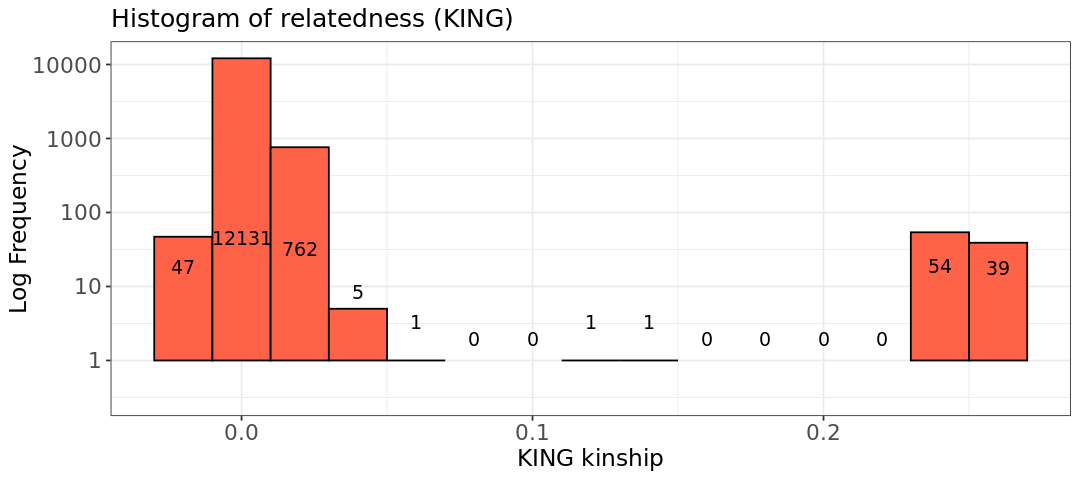

In [ ]:
hist.king <- ggplot(relatedness, aes(x=relatedness[,8])) +
  geom_histogram(binwidth = 0.02, col = "black", fill="tomato") + 
  labs(title = "Histogram of relatedness (KING)") + 
  xlab("KING kinship") + 
  ylab("Log Frequency") + 
  theme_bw() +
  scale_y_log10() +
  theme(axis.title=element_text(size=14), 
        axis.text=element_text(size=13),
        plot.title=element_text(size=15)) 

#Extract coordinates of the plot
bin_data <- ggplot_build(hist.king)$data[[1]]

#Adding text labels to  each bar, 
#accounting for log scale
hist.king + 
  geom_text(data = bin_data, 
            aes(x = xmin + (xmax - xmin) / 2, 
                y = log10(count+1),  # Apply log10
                label = count), 
                vjust = -5, #Vertical adjustment of text
                size = 4, 
                color = "black")

:::

---

We can also plot the number of SNPs used to calculate relatedness VS the KING relatedness itself. Pairs with very low number of SNPs and anomalous KING estimator might simply contain badly genotyped sample(s). This is not at all our case.

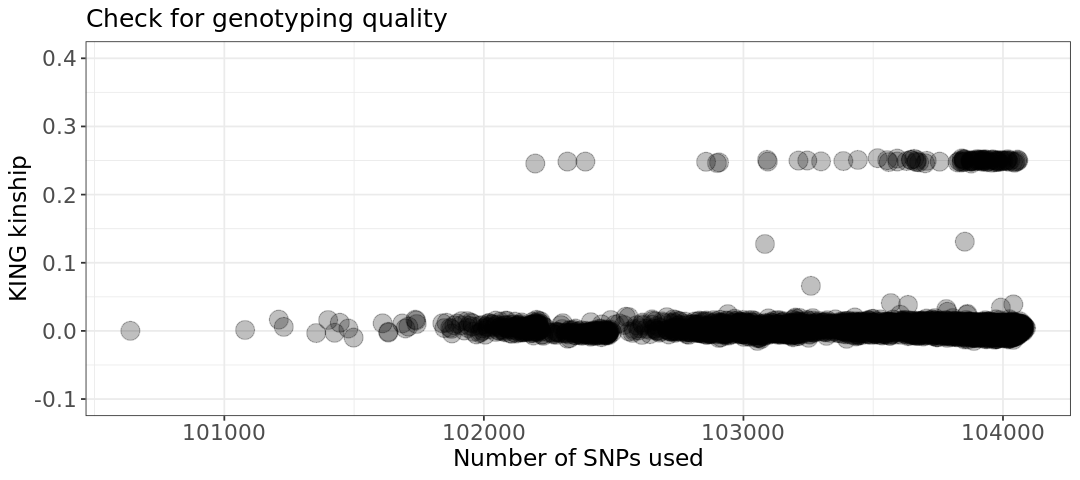

In [ ]:
# Relatedness plot
plot.relatedness <- ggplot(relatedness) +
  geom_point(aes(x=NSNP, y=KINSHIP), size=5, alpha=.25) + 
  ylim(-.1,.4) +
  labs(x = "Number of SNPs used", y = "KING kinship", title = "Check for genotyping quality") + 
  theme_bw() +
  theme(axis.title=element_text(size=14), 
        axis.text=element_text(size=13), 
        legend.text= element_text(size=13), 
        legend.title=element_text(size=14), 
        plot.title=element_text(size=15))

show(plot.relatedness)

:::{.callout-important title="Stop - Read - Solve"}
Use `PLINK` options to filter out related individuals, using a relatedness threshold of 0.1. 

- First of all you need to create a file with the IDs of the samples to remove. You can use the command `awk` as we did before in this exercise.

- Afterwards you need PLINK with the option `--remove` to use the file with IDs. Name the output `--out Results/GWAS4/king_exercise`.

:::

<img src="Images/bash.png" alt="Bash" width="40"> Switch to the Bash kernel.

In [ ]:
# Write your code here (PLINK command)


:::{.callout-tip title="Solution" collapse="true"}

We use `awk` to print IDs to remove and then the option `--remove` of PLINK. 


<img src="Images/bash.png" alt="Bash" width="40"> We print out all family and sample IDs for which the column KINSHIP (column 8) is >0.1. Note we print both samples in the pair with high relatedness, using the `awk` command twice.

In [ ]:
awk '{ if ($8 > 0.1) print $1, $2 }' Results/GWAS4/KING.kin0 > Results/GWAS4/filter_king.txt

Now each sample is identified uniquely ba family and sample ID. Some samples are repeated more than once because we have selected the first sample in related pairs, so same samples appear more than once. We use the option `--remove` to produce a new set of `plink` files. We will be warned about sample repetitions because we have been having some duplicates from the KINSHIP pairs

In [ ]:
plink --bfile Results/GWAS3/HapMap_3_r3_7 \
    --make-bed \
    --remove Results/GWAS4/filter_king.txt \
    --out Results/GWAS4/king_exercise

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/king_exercise.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_7
  --make-bed
  --out Results/GWAS4/king_exercise
  --remove Results/GWAS4/filter_king.txt

385567 MB RAM detected; reserving 192783 MB for main workspace.
1073226 variants loaded from .bim file.
162 people (78 males, 84 females) loaded from .fam.
110 phenotype values loaded from .fam.
--remove: 84 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 65 founders and 19 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate in remaining samples is 0.997556.
1073226 variants and 84 people pass filters and QC.
Among remaining phenotypes, 33 are cases and 32 are controls.  (19 phenotypes
are missing.)
--make-bed to Results/GWAS4/king_exercise.bed + Results/GWA

Let's grab from the log file what we have left of the data. `grep` finds a specific word in a text file.

In [ ]:
grep people Results/GWAS4/king_exercise.log

162 people (78 males, 84 females) loaded from .fam.
--remove: 84 people remaining.
1073226 variants and 84 people pass filters and QC.


:::

***

<img src="Images/bash.png" alt="Bash" width="40"> Switch to the Bash kernel.

So far, you’ve learned how to filter individuals using KING kinship thresholds. Now, we’ll demonstrate that most of the relatedness was due to parent-offspring relationships. We will achieve this by using the `--filter-founders` option to create a new filtered dataset that includes only the founders (individuals without listed parents in the data). This generates `.bed`, `.bim`, and `.fam` files, which are then used to create a `.kin0` file containing relatedness values. Note again we use `plink2` to create the KING matrix.

In [ ]:
plink --bfile Results/GWAS3/HapMap_3_r3_7 \
    --filter-founders \
    --make-bed \
    --out Results/GWAS4/HapMap_3_r3_8 \
    --silent

plink2 --bfile Results/GWAS4/HapMap_3_r3_8 \
    --extract Results/GWAS3/indepSNP.prune.in \
    --make-king-table \
    --out Results/GWAS4/KING_founders

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/KING_founders.log.
Options in effect:
  --bfile Results/GWAS4/HapMap_3_r3_8
  --extract Results/GWAS3/indepSNP.prune.in
  --make-king-table
  --out Results/GWAS4/KING_founders

Start time: Thu Mar 27 14:57:13 2025
385567 MiB RAM detected, ~343124 available; reserving 192783 MiB for main
workspace.
Using up to 64 threads (change this with --threads).
110 samples (55 females, 55 males; 110 founders) loaded from
Results/GWAS4/HapMap_3_r3_8.fam.
1073226 variants loaded from Results/GWAS4/HapMap_3_r3_8.bim.
1 binary phenotype loaded (55 cases, 55 controls).
--extract: 104144 variants remaining.
104144 variants remaining after main filters.
--make-king-table pass 1/1: Scanning for rare variants... done.
0 variants handled by initial scan (104144 remaining).
--make-king-table pass 1/1: Writing... done.
--make-kin

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

Let's plot the results from the `KING_founders.kin0` file. We can see how there is only 1 pair with high kinship amongst the founders.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_bar()`).”


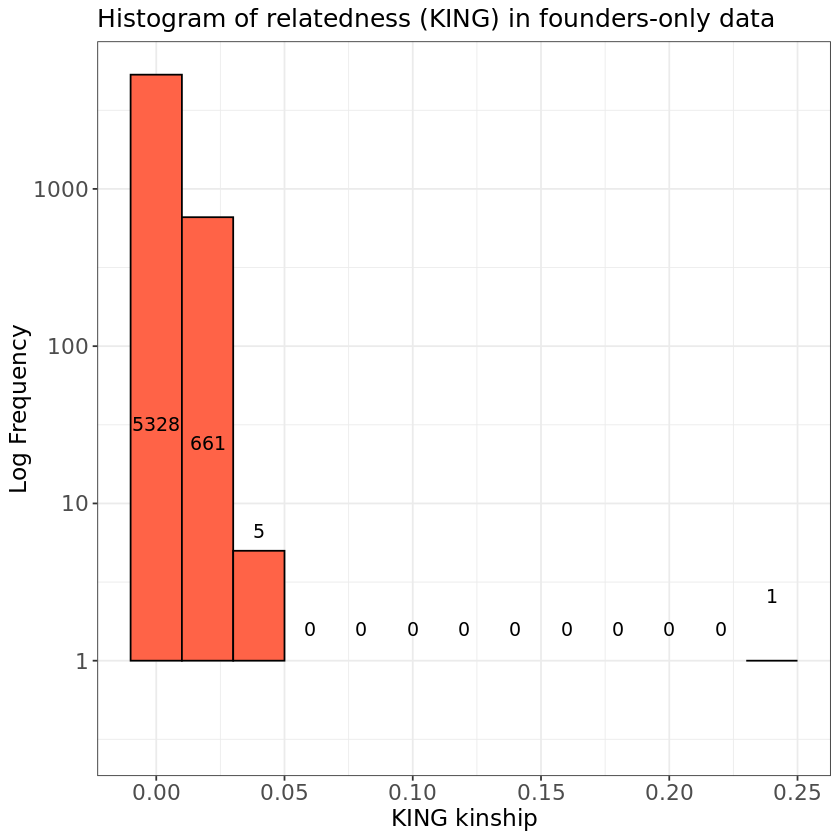

In [ ]:
suppressMessages(suppressWarnings(library(ggplot2)))

relatedness <- read.table("Results/GWAS4/KING_founders.kin0", header=TRUE, comment.char = '|')

hist.king <- ggplot(relatedness, aes(x=relatedness[,8])) +
  geom_histogram(binwidth = 0.02, col = "black", fill="tomato") + 
  labs(title = "Histogram of relatedness (KING) in founders-only data") + 
  xlab("KING kinship") + 
  ylab("Log Frequency") + 
  theme_bw() +
  scale_y_log10() +
  theme(axis.title=element_text(size=14), 
        axis.text=element_text(size=13),
        plot.title=element_text(size=15)) 

#Extract coordinates of the plot
bin_data <- ggplot_build(hist.king)$data[[1]]

#Adding text labels to  each bar, 
#accounting for log scale
hist.king + 
  geom_text(data = bin_data, 
            aes(x = xmin + (xmax - xmin) / 2, 
                y = log10(count+1),  # Apply log10
                label = count), 
                vjust = -10, #Vertical adjustment of text
                size = 4, 
                color = "black")

:::{.callout-important title="Stop - Read - Solve"}

- **1. Do you observe anything unexpected in the plot?**
- **2. Can you identify the IIDs of the sample pair?** Hint: filter for KINSHIP values.
- **3. Based on the KINSHIP, what is the most likely relationship between the pair?**
- **4. What would you do about it?** Hint: remove one or both in the pair?

:::

In [ ]:
# Write your answer here

In [ ]:
# R code here

:::{.callout-tip title="Solution" collapse="true"}

- **1.** The file `KING_founders.kin0` shows that, after excluding all non-founders, one individual pair removed in the exercise remains in the HapMap data. 
- **2.** Below, we can look at the individual from the table by setting KINSHIP > 0.2. Even if labeled as unrelated, it has high relatedness. The IIDs of the pair are NA07045 and NA12813. 


In [ ]:
relatedness[relatedness$KINSHIP > 0.2,]

,X.FID1,IID1,FID2,IID2,NSNP,HETHET,IBS0,KINSHIP
,<int>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
2729,1454,NA12813,13291,NA07045,103668,0.21402,0.0186171,0.247858


- **3.** This remaining individual is likely to be related with sibling relationship, even though they were not given the same family identity (FID) in the HapMap data.
- **4.** We don't need to remove both individuals from the dataset (IID1=NA07045; IID2=NA12813). It's enough to remove just one, and the individual with the highest missing rate (lowest quality) could be chosen. Let's calculate the missing rates using PLINK.

:::

***

<img src="Images/bash.png" alt="Bash" width="40"> Switch to the Bash kernel.

In [ ]:
plink --bfile Results/GWAS4/HapMap_3_r3_8 \
    --missing \
    --out Results/GWAS4/HapMap_3_r3_8 \
    --silent

Then, find the two individuals from the output file using `grep` and sorting descendingly by missing rate (EZ, column 6)

In [ ]:
# Let's look at the output
cat Results/GWAS4/HapMap_3_r3_8.imiss | grep -E 'NA07045|NA12813' | sort -k6,6nr

  13291   NA07045          N     2552  1073226 0.002378
   1454   NA12813          N     1947  1073226 0.001814


`NA07045` is the individual to be removed. Once this is removed, their offspring can still be used in analyses that don't involve trios, such as family-related studies.

:::{.callout-important title="Stop - Read - Solve"}

- **Plot the distribution of missing rates from `HapMap_3_r3_8`. What is the value for `NA07045`?**
- **Remove `NA07045` from the PLINK files**
  
Hint: 

- Use the `.imiss` file to plot a histogram of the missing scores from the file `HapMap_3_r3_8.imiss` in `R` (check previous notebooks for help). Is the score of `NA07045` amongst the higher/lower ones? You can add a vertical line in the histogram representing the value for `NA07045` using `geom_vline`. 
- Create a file with the sample ID to remove and use the `--remove` option in PLINK. 

:::

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

In [ ]:
# Write your code here

:::{.callout-tip title="Solution" collapse="true"}
We can extract the column from the file and observe in the histogram that the individual `NA07045` has a missing rate closer to the bulk of other samples.


,FID,IID,MISS_PHENO,N_MISS,N_GENO,F_MISS
,<int>,<chr>,<chr>,<int>,<int>,<dbl>
1,1328,NA06989,N,2181,1073226,0.0020320
2,1377,NA11891,N,13586,1073226,0.0126600
3,1349,NA11843,N,813,1073226,0.0007575
4,1330,NA12341,N,3697,1073226,0.0034450
5,1328,NA06984,N,6478,1073226,0.0060360
6,1418,NA12275,N,2717,1073226,0.0025320


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


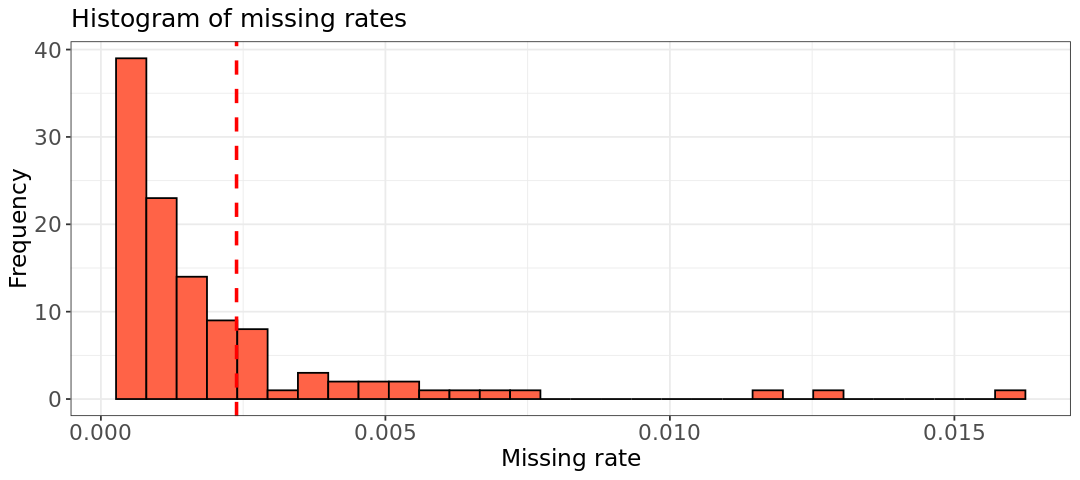

In [ ]:
suppressMessages(suppressWarnings(library(ggplot2)))

options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
smiss <- read.table("Results/GWAS4/HapMap_3_r3_8.imiss", header=T)

head(smiss)

hist.relatedness <- ggplot(data=smiss, aes(F_MISS)) +
  geom_histogram(col = "black", fill = "tomato") + 
  geom_vline(xintercept = 0.002384, color = "red", linetype = "dashed", linewidth = 1) +
  labs(title = "Histogram of missing rates") + 
  xlab("Missing rate") + 
  ylab("Frequency") + 
  theme_bw() +
  theme(axis.title=element_text(size=14), axis.text=element_text(size=13),plot.title=element_text(size=15))

show(hist.relatedness)


<img src="Images/bash.png" alt="Bash" width="40"> Switch to the Bash kernel.

To remove the individual from the data, we create a file containing its number and ID, and provide it to PLINK with the option `--remove`

In [ ]:
echo "13291  NA07045" > Results/GWAS4/id_remove.txt

In [ ]:
plink --bfile Results/GWAS4/HapMap_3_r3_8 \
    --remove Results/GWAS4/id_remove.txt \
    --make-bed \
    --out Results/GWAS4/HapMap_3_r3_9 \
    --silent

:::

---

:::{.callout-important title="Challenge yourself: relatedness in mice data"}

Use the mice data you filtered in the exercise of GWAS3, or if you do not have it, use the initial mice data.

1 - Calculate the kinship matrix and plot the values on the histogram.

2 - Why do you get those values in the plot? What could be happening? Remember those are mice!

3 - Now try instead to use `plink` with the option `--genome`. This calculates the IBD estimator called pi_hat. You need `--bfile` for the input data and `--out` for the name of the output table.

4 - Plot again the histogram using the table (column PI_HAT). Now you should have values bounded between (0,1) on the x axis.

5 - Values around 0.25 are second-degree relationships (half siblings), around 0.5 are parent-child and siblings. Usually, a pi_hat much above 0.5 is trace of duplicates, or inbreeding (the second is likely our case, or we would have really bad data with too many duplicates). We have also some sample pairs with a pi_hat=1. What could the respective samples be?

:::

In [ ]:
#Write your code here or create a copy of this notebook to work on

::: {.callout-tip}

# Click to view answers
<i class="bi bi-journal-code"></i> [GWAS4 relatedness solution](exercises/gwas4-mice.ipynb)

:::

:::{.callout-note title="Wrapping up"}

You have now successfully checked your data for relatedness. You filtered out the individuals with high relatedness and can continue in the next notebook to check population structure.

In the next notebook on **Association Testing**, you will need the following files from the folder `Results/GWAS4/`:
- `HapMap_3_r3_10` (the bfile, i.e., `HapMap_3_r3_10.bed`, `HapMap_3_r3_10.bim`, and `HapMap_3_r3_10.fam`)
- `covar_mds.txt`
which are the HapMap data and the MDS covariates highlighting the population stratification. Those are already available once you have been running this notebook.

Below is a cheat sheet of our new methods from this notebook. Again, it is important to remember that each method of QC should be justified, which will depend on the nature of the feature you are trying to analyze.


| Step| Command| Function| Thresholds and explanation|
|------------------------------|------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 6: Relatedness | `--make-king-table` (PLINK2)| Calculates KING kinship of all sample pairs. The KING kinship is more reliable in presence of population structure.| Use independent SNPs (pruning) for this analysis and limit it to autosomal chromosomes only.|
| - | `--genome` (PLINK)| Calculates the pi_hat IBD estimator of all sample pairs. It is made to be bound between 0 and 1, but can in some extreme cases go out of this interval. It can be useful as a second check when having very weird KING values ((see our mice exercise)[exercise/gwas4-mice.ipynb]).| Use independent SNPs (pruning) for this analysis and limit it to autosomal chromosomes only.|
| - | `awk` + `--remove` | Sets threshold and creates a list of individuals with relatedness above the chosen threshold (`awk` command). This means that subjects who are related at, for example, KINSHIP > 0.1 (i.e., half siblings, or siblings, or parent-child) can be detected, or PI_HAT>.25 (matching the mentioned KING relationships). | Cryptic relatedness can interfere with the association analysis. If you  have a family‐based sample (e.g., parent‐offspring), you do not need to remove related pairs but the statistical analysis should take family relatedness into account. However, for a population-based sample, we suggest using a KINSHIP threshold of 0.06, which is in line with the literature using IBD kinship thresholds (Anderson et al.,  2010; Guo et al.,  2014). |

:::

# Bibliography